In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra, Plots
using ProgressMeter
import ForwardDiff as FD
import Convex as cvx
import ECOS

include(joinpath(@__DIR__,"fmincon.jl"))

  Activating environment at `~/Desktop/Projects/OptimalSailboat/trajectory_optimizer/Project.toml`


fmincon (generic function with 1 method)

In [2]:
"""
Converts from cartesian (x,y) to polar (r,θ) coordinates.
"""
function car2pol(x, y)
    r = √(x^2 + y^2)
    θ = atan(y, x)
    return r, θ
end;

"""
Wraps an angle (in radians) to the range [-π, π].
"""
function wrap2pi(θ)
    return θ - 2*π*floor((θ+π)/(2*π))
end;

"""
Converts from a vector of vectors to a matrix.
"""
function vec2mat(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end;

"""
Converts from a matrix to a vector of vectors.
"""
function mat2vec(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end;

### Variable Definitions

#### State Variables:
 - $(x_o, y_o)$ - global position
 - $\theta$ - global orientation
 - $v$ - velocity
 - $\dot{\theta}$ - angular velocity

#### Control Variables:
 - $\delta_r$ - rudder angle
 - $\delta_s$ - sail angle

#### Wind and Force Variables:
 - $a_{tw}$ - true wind speed
 - $\psi_{tw}$ - true wind direction
 - $g_s$ - force from sail
 - $g_r$ - force from rudder

#### Parameters:
 - $p_1$ - drift coefficient
 - $p_2$ - tangential friction
 - $p_3$ - angular friction
 - $p_4$ - sail lift
 - $p_5$ - rudder lift
 - $p_6$ - distance to sail CoE (center of effort)
 - $p_7$ - distance to mast
 - $p_8$ - distance to rudder
 - $p_9$ - mass of boat
 - $p_{10}$ - moment of inertia
 - $p_{11}$ - rudder break coefficient


### System Model

#### State and Input Arrays:
$$ \begin{align}
x &= \begin{bmatrix} x_{b} & y_{b} & \theta & v & \dot{\theta} \end{bmatrix} ^T \\
u &= \begin{bmatrix} \delta_r & \delta_s \end{bmatrix} ^T
\end{align} $$

#### True Wind:
$$ \begin{align}
\dot{x}_{tw} &= w_x(x_b, y_b) \\
\dot{y}_{tw} &= w_y(x_b, y_b) \\
a_{tw} &= \sqrt{\dot{x}_{tw}^2 + \dot{y}_{tw}^2}  \\
\psi_{tw} &= \arctan{(\frac{\dot{y}_{tw}}{\dot{x}_{tw}})} \\
\end{align} $$

#### Apparent Wind:
$$ \begin{align}
\dot{x}_{aw} &= a_{tw} \cos{(\psi_{tw} - \theta)} - v \\
\dot{y}_{aw} &= a_{tw} \sin{(\psi_{tw} - \theta)} \\
a_{aw} &= \sqrt{\dot{x}_{aw}^2 + \dot{y}_{aw}^2}  \\
\psi_{aw} &= \arctan{(\frac{\dot{y}_{aw}}{\dot{x}_{aw}})} \\
\end{align} $$

#### Sail and Rudder Forces:
$$ \begin{align}
g_s &= p_4 a_{aw} \sin{(\delta_s - \psi_{aw})} \\
g_r &= p_5 v^2 \sin{\delta_r}
\end{align} $$

#### Dynamics

$$ \begin{align}
\dot{x} = f(x, u, w) &= 
    \begin{bmatrix}
        v \cos{\theta} + p_1 a_{tw} \cos{\psi_{tw}} \\
        v \sin{\theta} + p_1 a_{tw} \sin{\psi_{tw}} \\
        \dot{\theta} \\
        \frac{g_s \sin{\delta_s} - g_r p_{11} \sin{\delta_r} - p_2 v^2}{p_9} \\
        \frac{g_s (p_6 - p_7 \cos{\delta_s}) - g_r p_8 \cos{d_r} - p_3 \dot{\theta} v}{p_{10}}
    \end{bmatrix}
\end{align} $$

In [3]:
"""
true wind velocity (vector field)
"""
function true_wind(xₒ, yₒ)
    ẋ_tw = 1.
    ẏ_tw = 0.
    return ẋ_tw, ẏ_tw
end;

"""
dynamics
"""
function dynamics(x, u, p)
    xₒ, yₒ, θ, v, θ̇ = x
    δᵣ, δₛ = u
    
    # true wind
    ẋ_tw, ẏ_tw = true_wind(xₒ, yₒ)
    a_tw, ψ_tw = car2pol(ẋ_tw, ẏ_tw)
    
    # apparent wind
    ẋ_aw = a_tw * cos(ψ_tw - θ) - v
    ẏ_aw = a_tw * sin(ψ_tw - θ)
    a_aw, ψ_aw = car2pol(ẋ_aw, ẏ_aw)
    
    # forces
    gₛ = p[4] * a_aw * sin(δₛ - ψ_aw)
    gᵣ = p[5] * v^2 * sin(δᵣ)

    # dynamics
    ẋ = [v*cos(θ) + p[1]*a_tw*cos(ψ_tw),
         v*sin(θ) + p[1]*a_tw*sin(ψ_tw),
         θ̇,
         (gₛ*sin(δₛ) - gᵣ*p[11]*sin(δᵣ) - p[2]*v^2)/(p[9]),
         (gₛ*(p[6] - p[7]*cos(δₛ)) - gᵣ*p[8]*cos(δᵣ) - p[3]*θ̇*v)/(p[10])]

    return ẋ
end;

In [4]:
# Test
let
    p = [0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2]
    x = [0.0, 0.0, 0.0, 0.0, 0.0]
    u = [0.0, π/32]
    dynamics(x, u, p)
end

5-element Vector{Float64}:
 0.03
 0.0
 0.0
 0.006404906532256517
 0.00011799483037411598

### Linearization

$$ \begin{align}
A_c &= \frac{\delta f}{\delta x} \\
B_c &= \frac{\delta f}{\delta u}
\end{align} $$

In [5]:
"""
linear dynamics about a point
"""
function linearized_dynamics(x, u, p)
    Ac = FD.jacobian(_x -> dynamics(_x, u, p), x)
    Bc = FD.jacobian(_u -> dynamics(x, _u, p), u)

    return Ac, Bc
end;

In [26]:
# Test
let
    p = [0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2]
    x = [0.0, 0.0, 0.0, 0.0, 0.0]
    u = [0.0, π/32]
    linearized_dynamics(x, u, p)
end

([0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … -0.006404906532256517 0.0; 0.0 0.0 … -0.00011799483037411598 0.0], [0.0 0.0; 0.0 0.0; … ; 0.0 0.13006021467741882; 0.0 0.0035998615672415985])

### Discretization

In [6]:
"""
discretize a linear system using the matrix exponential
"""
function discretize(Ac, Bc, Δt)
    nx, nu = size(Bc)

    # continuous-time block for [x u] state
    Blockc = [Ac Bc;
              zeros(nu,nx+nu)]
    
    # discrete-time block for [x u] state
    Block = exp(Blockc*Δt)
    
    A = Block[1:nx, 1:nx]
    B = Block[1:nx, nx+1:nx+nu]
    
    return A, B
end;

In [28]:
# Test
let
    p = [0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2]
    x = [0.0, 0.0, 0.0, 0.0, 0.0]
    u = [0.0, π/32]
    Δt = 0.1
    Ac, Bc = linearized_dynamics(x, u, p)
    discretize(Ac, Bc, Δt)
end

([1.0 0.0 … 0.09996798227141845 1.0836622470646206e-5; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 0.9993597131386678 0.0003250814537125254; 0.0 0.0 … -1.1795728667260341e-5 1.0000059888354023], [0.0 0.0006501632335685491; 0.0 0.0; … ; 0.0 0.013001896245429837; 0.0 0.00035991015953286377])

### Integration

In [4]:
"""
Runge-Kutta (4th order) explicit integration.
"""
function rk4(x, u, p, Δt)
    k1 = Δt*dynamics(x, u, p)
    k2 = Δt*dynamics(x + k1/2, u, p)
    k3 = Δt*dynamics(x + k2/2, u, p)
    k4 = Δt*dynamics(x + k3, u, p)

    x_next = x + (k1 + 2*k2 + 2*k3 + k4)/6
    x_next[3] = wrap2pi(x_next[3])
    
    return x_next
end;

"""
Hermite-Simpson implicit integration.
"""
function hermite_simpson(x1::Vector, x2::Vector, u, p::Vector, Δt::Real)::Vector 
    ẋ1 = dynamics(x1, u, p)
    ẋ2 = dynamics(x2, u, p)
    x_mid = (x1 + x2)/2 + Δt*(ẋ1 - ẋ2)/8
    return x1 + Δt*(ẋ1 + 4*dynamics(x_mid, u, p) + ẋ2)/6 - x2
end;

### Plotting

In [5]:
function plot_boat(x, u, p)
    xₒ, yₒ, θ, v, θ̇ = x
    δᵣ, δₛ = u

    k₁ = 0.4 # boat width scale factor
    k₂ = 0.3 # rudder scale factor
    k₃ = 1.5 # sail scale factor

    points = [xₒ + (p[6]+p[7])*cos(θ)           yₒ + (p[6]+p[7])*sin(θ);
              xₒ + k₁*p[7]*sin(θ) + p[6]*cos(θ) yₒ - k₁*p[7]*cos(θ) + p[6]*sin(θ);
              xₒ + k₁*p[7]*sin(θ) - p[7]*cos(θ) yₒ - k₁*p[7]*cos(θ) - p[7]*sin(θ);
              xₒ - k₁*p[7]*sin(θ) - p[7]*cos(θ) yₒ + k₁*p[7]*cos(θ) - p[7]*sin(θ);
              xₒ - k₁*p[7]*sin(θ) + p[6]*cos(θ) yₒ + k₁*p[7]*cos(θ) + p[6]*sin(θ);
              xₒ + (p[6]+p[7])*cos(θ)           yₒ + (p[6]+p[7])*sin(θ);]

    # body
    plot!(points[1:end,1], points[1:end,2],
          color=:black, fill=(0, 0.1, :black), label=false)

    # rudder
    plot!([xₒ-p[7]*cos(θ), xₒ-p[7]*cos(θ)-k₂*p[7]*cos(θ+δᵣ)],
          [yₒ-p[7]*sin(θ), yₒ-p[7]*sin(θ)-k₂*p[7]*sin(θ+δᵣ)],
          color=:blue, label=false)

    # sail
    plot!([xₒ+p[6]*cos(θ), xₒ+p[6]*cos(θ)-k₃*p[6]*cos(θ+δₛ)],
          [yₒ+p[6]*sin(θ), yₒ+p[6]*sin(θ)-k₃*p[6]*sin(θ+δₛ)],
          color=:blue, label=false)
end;

function plot_wind(xlims, ylims)
      points = vcat([(x,y) for x=LinRange(xlims...,20), y=LinRange(ylims...,20)]...)
      vectors = [true_wind(p...) for p=points]
      quiver!(points, quiver=vectors)
end;

function plot_waypoint(x, y, label)
      scatter!([x], [y], label=label)
end

function plot_scene(x, u, p; waypoints=(), xlims=(-20,20), ylims=(-20,20))
      scene = plot(size=(800,800), xlims=xlims, ylims=ylims, aspect=:equal)
      plot_boat(x, u, p)
      plot_wind(xlims, ylims)
      for waypoint = waypoints
            plot_waypoint(waypoint...)
      end
      
      return scene
end;

function plot_trajectory(Xm, Um, p; waypoints=(), xlims=(-20,20), ylims=(-20,20))
      scene = plot(size=(800,800), xlims=xlims, ylims=ylims, aspect=:equal)
      plot_boat(Xm[:,end], Um[:,end], p)
      plot_wind(xlims, ylims)
      for waypoint = waypoints
            plot_waypoint(waypoint...)
      end
      plot!(Xm[1,:],Xm[2,:],
            xlabel = "x position (m)", ylabel = "y position (m)",
            label="Trajectory")
      return scene
end;

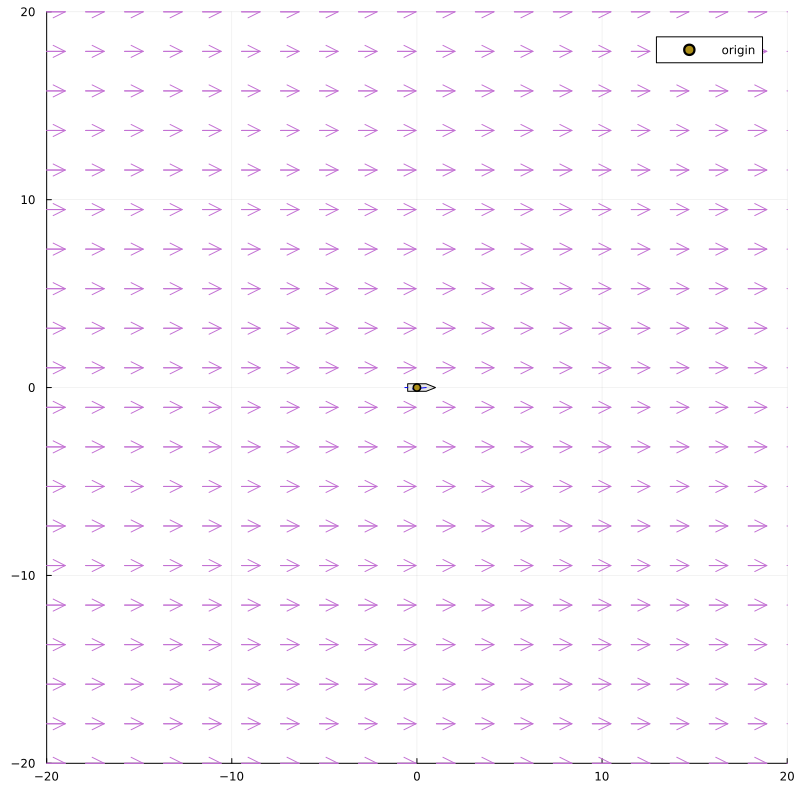

In [31]:
let
    p = [0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2]
    x = [0.0, 0.0, 0.0, 0.0, 0.0]
    u = [0.0, π/32]
    plot_scene(x, u, p, waypoints=[(0,0,"origin")])
end

┌ Info: Saved animation to /Users/taerugh/Desktop/Projects/OptimalSailboat/output/test_anim.gif
└ @ Plots /Users/taerugh/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/taerugh/Desktop/Projects/OptimalSailboat/output/test_anim.gif")
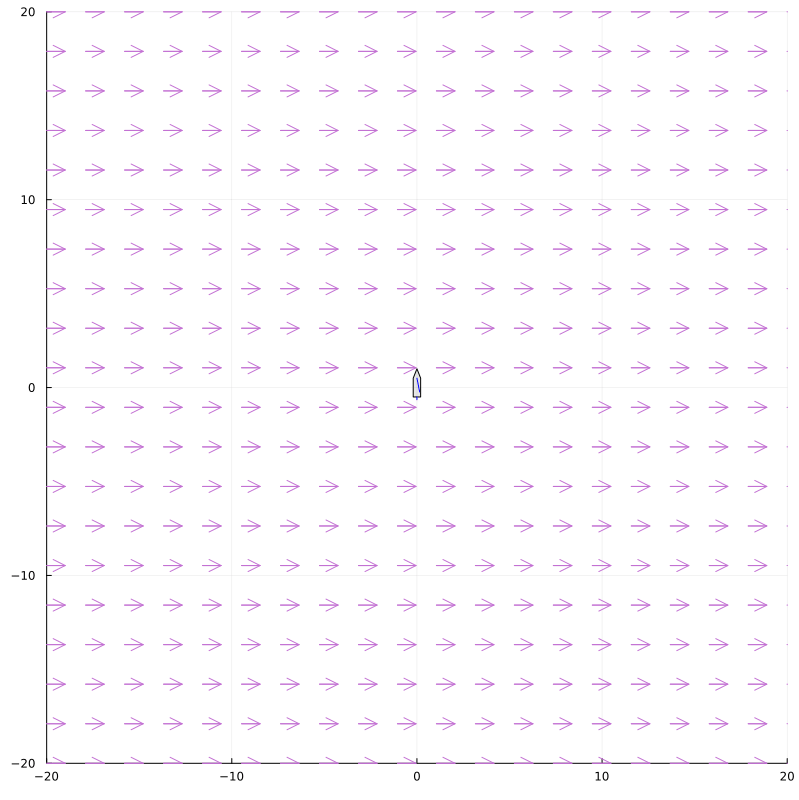

In [32]:
let 
    n = 100
    p = [0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2]
    x = [0.0, 0.0, π/2, 0.0, 0.0]
    u = [0, π/16]
    Δt = 0.1
    anim = @animate for i ∈ 1:n
        plot_scene(x, u, p)
        x = rk4(x, u, p, Δt)
    end
    gif(anim, "output/test_anim.gif", fps = 15)
end

### Trajectory Planning (Direct Collocation)

$$ \begin{align}

\min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{goal})^TQ(x_i - x_{goal}) + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}(x_N - x_{goal})^TQ_f(x_N - x_{goal}) \\ 

 \text{s.t.} \quad & x_1 = x_{\text{IC}} \\
 & f_{hs}(x_i,x_{i+1},u_i,dt) = 0 \quad \text{for } i = 1,2,\ldots,N-1 \\
 & \frac{-\pi}{3} \leq u_i \leq \frac{\pi}{3} \quad \text{for } i = 1,2,\ldots,N-1

 \end{align} $$

In [6]:
"""
This function creates some useful indexing tools for Z.
    Z = [x0, u0, x1, u1, …, xN]
    x_i = Z[idx.x[i]]
    u_i = Z[idx.u[i]]
"""
function create_idx(nx,nu,N)
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx

    return (nx=nx ,nu=nu, N=N, nz=nz, nc=nc, x=x, u=u, c=c)
end

function sailboat_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        J += 0.5*(xi - xg)'*Q*(xi - xg)
        # J += 0.5*ui'*R*ui
    end

    xf = Z[idx.x[N]]
    J += 0.5*(xf - xg)'*Qf*(xf - xg)
    
    return J 
end

function sailboat_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt, p = params.idx, params.N, params.dt, params.p

    c = zeros(eltype(Z), idx.nc)
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        c[idx.c[i]] = hermite_simpson(xi, xip1, ui, p, dt)
        # c[idx.c[i]] = xip1 - rk4(xi, ui, p, dt)
    end

    return c
end

function sailboat_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg

    c = [Z[idx.x[1]] - xic; # initial condition
        #  Z[idx.x[N]] - xg;  # terminal constraint
         sailboat_dynamics_constraints(params, Z)]
    
    return c
end

function solve_sailboat_trajectory(xic, xg, nu, p, tf, dt; verbose=true)
    # problem size
    nx = length(xic)
    t_vec = 0:dt:tf
    N = length(t_vec)
    
    # LQR cost 
    Q = diagm([1,1,0,0,0])
    R = 0.1*diagm(ones(nu))
    Qf = 10*Q
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # load all useful things into params 
    params = (Q=Q, R=R, Qf=Qf, xic=xic, xg=xg, dt=dt, N=N, idx=idx, p=p)
    
    # primal bounds 
    x_l = -Inf*ones(idx.nz)
    for i = 1:length(idx.u)
        x_l[idx.u[i]] .= -π/3
    end

    x_u = Inf*ones(idx.nz)
    for i = 1:length(idx.u)
        x_u[idx.u[i]] .= π/3
    end
    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
#     diff_type = :finite
    
    Z = fmincon(sailboat_cost, sailboat_equality_constraint, inequality_constraint,
                x_l, x_u, c_l, c_u, z0, params, diff_type;
                tol=1e-6, c_tol=1e-6, max_iters=10_000, verbose=verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end;

In [7]:
p = [0.03, 40, 6000, 200, 1500, 0.5, 0.5, 2, 300, 400, 0.2]
Δt = 0.5
tf = 25
nx = 5
nu = 2

xic = [0.0, 0.0, π/2, 0.0, 0.0]
xg = [-5.0, 15.0, 0.0, 0.0, 0.0]

X, U, t_vec = solve_sailboat_trajectory(xic, xg, nu, p, tf, Δt; verbose=false);
Xm = vec2mat(X)
Um = vec2mat(U)

In [46]:
fig = plot_trajectory(Xm, Um, p, waypoints=[(xic[1],xic[2],"initial"), (xg[1],xg[2],"goal")], xlims=(-15,10), ylims=(-5,20))
savefig(fig, "output/sailboat_trajectory.png")
display(fig)

"/Users/taerugh/Desktop/Projects/OptimalSailboat/trajectory_optimizer/output/sailboat_trajectory.png"

┌ Info: Saved animation to /Users/taerugh/Desktop/Projects/OptimalSailboat/trajectory_optimizer/output/dircol_5.gif
└ @ Plots /Users/taerugh/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/taerugh/Desktop/Projects/OptimalSailboat/trajectory_optimizer/output/dircol_5.gif")
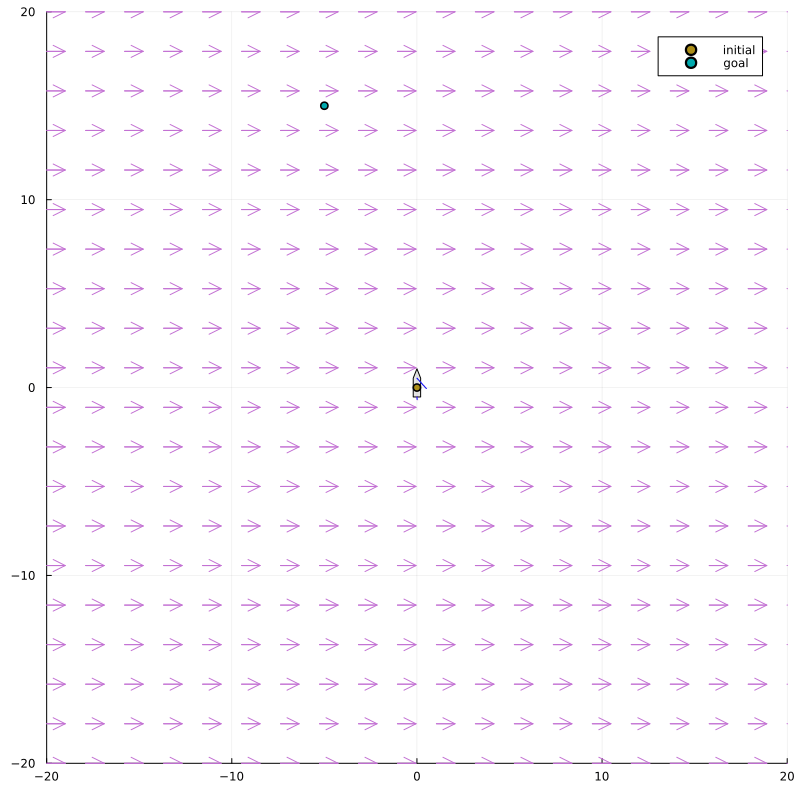

In [18]:
anim = @animate for i ∈ 1:length(t_vec)-1
    plot_scene(X[i], U[i], p, waypoints=[(xic[1],xic[2],"initial"), (xg[1],xg[2],"goal")])
end
gif(anim, "output/dircol_5.gif", fps = 15)

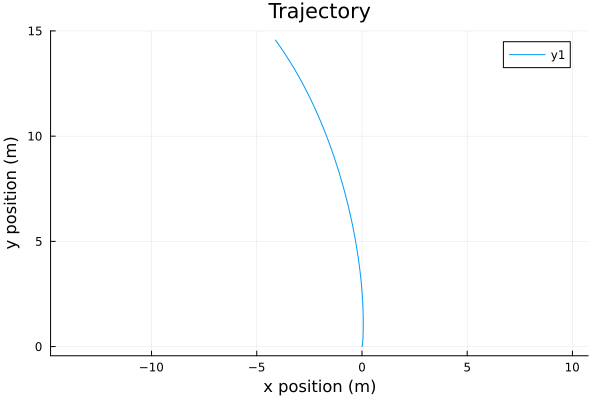

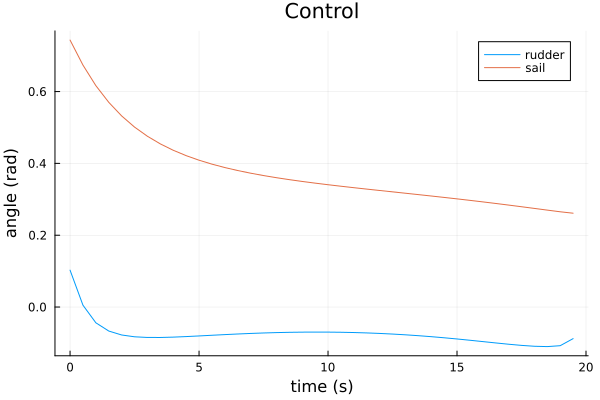

"/Users/taerugh/Desktop/Projects/OptimalSailboat/trajectory_optimizer/output/control_trajectory.png"

In [45]:
fig = plot(t_vec[1:end-1],Um[1:2,:]',title = "Control",
           xlabel = "time (s)", ylabel = "angle (rad)",
           label = ["rudder" "sail"])
display(fig)
savefig(fig, "output/control_trajectory.png")